In [1]:
%matplotlib inline
import os

root = os.path.dirname(os.getcwd())
data_dir = os.path.join(root,"Data")

In [2]:
import json
import math
import numpy as np
import pandas as pd
import geoplot
import geopandas as gpd
import matplotlib.pyplot as plt 
from progressbar import ProgressBar

#Dataframe
df = pd.read_csv(os.path.join(data_dir,"Babies_names.csv"), delimiter = ";", index_col = "Id")

#States Hash
with open(os.path.join(os.path.join(data_dir,"Support"),"states_hash.json")) as f:
    states_hash = json.load(f)
    
#Geomap
map_df = gpd.read_file(os.path.join(os.path.join(data_dir,"Support"),"usa_states_geo.json"))

We fix a few details with the columns names and check how our data looks and its properties

In [3]:
#We add  the full State name to the babies dataframe
df['State'] = df.apply(lambda x: states_hash[x.State], axis=1)
map_df.rename(columns={'NAME':'State'}, inplace=True)
map_df.drop(columns = "STATE")

#Also, we take away Alaska, Puerto Rico and Hawaii from both dataframes just for visual comodity
to_exclude = ["Alaska","Hawaii","Puerto Rico"]

df = df[~df["State"].isin(to_exclude)]
continental_usa = map_df[~map_df["State"].isin(to_exclude)]

display(df.head(2), df.shape)
display(continental_usa.head(2), continental_usa.shape)
display("Details about the geometry object we have",continental_usa.crs)

,Name,Year,Gender,State,Count
Id,,,,,
85244,Emma,2004,F,Alabama,388
85245,Madison,2004,F,Alabama,382


(885819, 5)

,GEO_ID,STATE,State,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,,50645.326,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ..."
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0..."


(49, 6)

'Details about the geometry object we have'

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

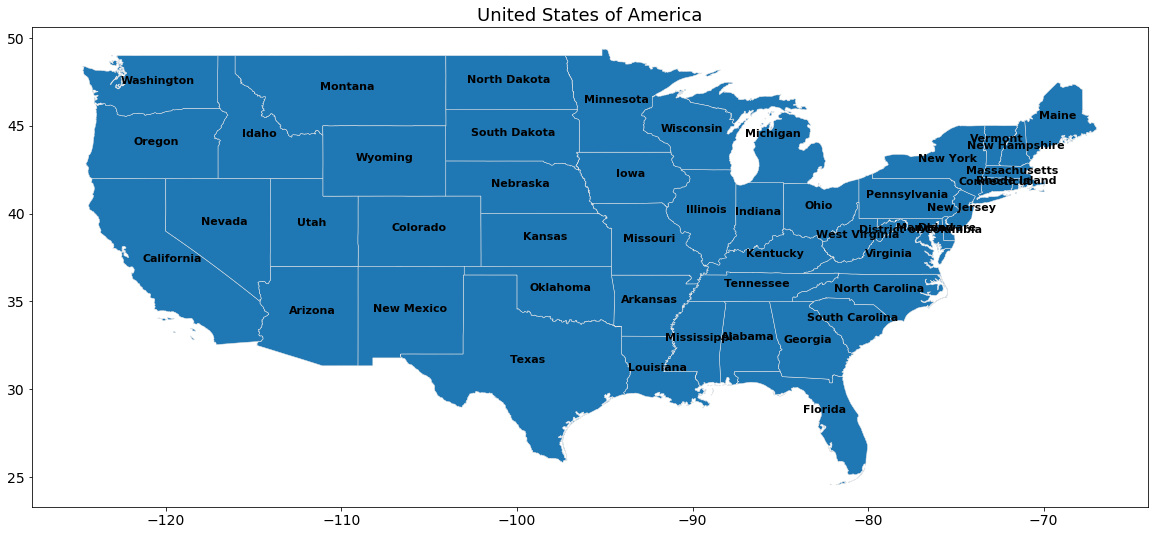

In [4]:
# Define the variable that will be called in the upcoming map
variable = "State"

# Set the range for the choropleth
vmin, vmax = 120, 150

# Create figure and axes for Matplotlib plus the font config
fig, ax = plt.subplots(1, figsize=(20, 20))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title("United States of America",fontdict={'fontsize': 18, 'fontweight': 'medium'})

continental_usa.plot(linewidth=0.5,ax=ax,edgecolor="0.9",missing_kwds={'color': 'lightgrey'})
continental_usa.apply(lambda x: ax.annotate(s=x[variable], 
                                    xy=x.geometry.centroid.coords[0],
                                    ha='center',
                                    color='black',
                                    fontsize=11,
                                    fontweight='bold'),axis=1);

# Lets get on it

### Most common names by gender and state for each year (2004-2014)

First of all I change the index of our babies dataframe so that we can execute the querys in an easier way (not necessarily more efficient)

In [5]:
df.set_index(["Year","Gender"],inplace=True)

We obtain the most common name for each state during each year of available data for both genders and finally store it in a pandas dataframe

In [6]:
results=[]
pbar = ProgressBar()

for i in pbar(range(2004,2015)):
    for gender in ["F","M"]:
        for state in list(df.State.unique()):
            query = df.query('Year == @i and Gender == @gender and State == @state')
            mode = query.loc[query['Count'] == query["Count"].max()]
            try:
                results.append([i,gender,state,mode.iloc[0][0],mode.iloc[0][2]])
            except:
                results.append([i,gender,state, np.nan, np.nan])
                
results_df = pd.DataFrame(results, columns = ["Year","Gender","State","Name","Count"])

100% (11 of 11) |########################| Elapsed Time: 0:01:22 Time:  0:01:22


Now we can select the data wich we want to plot in a quite simple way.<br>

In [7]:
results_df[(results_df["Year"]==2004) & (results_df["Gender"]=="F")].head()

,Year,Gender,State,Name,Count
0,2004,F,Alabama,Emma,388.0
1,2004,F,Arkansas,Madison,281.0
2,2004,F,Arizona,Emily,445.0
3,2004,F,California,Emily,3416.0
4,2004,F,Colorado,Emma,336.0


Before plotting it we will need to merge this with the spatial data we have inside the <b>continental_usa</b> geodataframe.<br>

To make that easier we create the next 2 functions:

In [8]:
def merge(geo_map, info_df, gender, year):
    
    interest_df = info_df[(info_df["Year"]==year) & (info_df["Gender"]==gender)].copy()
    interest_df = interest_df.astype({"Count": float})
    interest_df["us_rate"] = interest_df.apply(lambda x: round(x.Count/interest_df.Count.sum(),3),axis=1)
        
    geo_map_aux = geo_map.copy()
    geo_map_aux = geo_map_aux.merge(interest_df, on='State', how="outer")
 #   geo_map_aux = geo_map_aux.astype({"Count": float})
    
    return geo_map_aux

def freq_map(df,year,gender):
    # set a variable that will call whatever column we want to visualise on the map
    variable = "Count"

    # set the range for the choropleth
    vmin, vmax = 120, 150

    # Create figure and axes for Matplotlib plus the font config
    fig, ax = plt.subplots(1, figsize=(25, 15))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    #Plot
    df.plot(column=variable,
                 cmap="YlOrRd",
                 linewidth=0.8,
                 ax=ax,
                 edgecolor="0.8",
                 missing_kwds={'color': 'lightgrey'},
                 legend=True,
                 cax=cax,
                 )

    ax.set_title("Most common %s babies names by state in U.S year %i" %(genders[gender],year),
                 fontdict={'fontsize': 18, 'fontweight': 'medium'})

    df.apply(lambda x: ax.annotate(s=str(x.Name), 
                                        xy=x.geometry.centroid.coords[0],
                                        ha='center',
                                        color='black',
                                        fontsize=11,
                                        fontweight='bold') if not math.isnan(x.Count) else 0 ,axis=1);
    plt.show()

Repeating the example shown in cell [7] we would obtain the next output

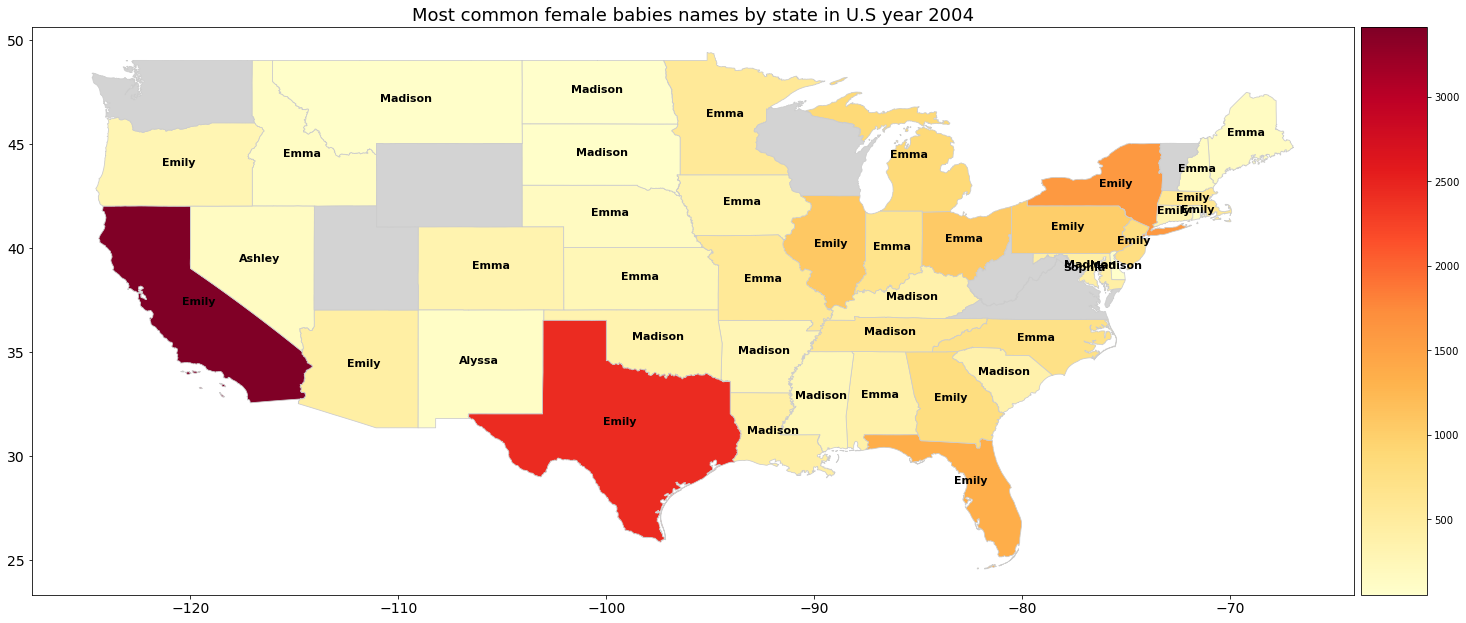

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

year = 2004
gender = "F"
genders = {"F": "female", "M": "male"}

ejemplo = merge(continental_usa, results_df, gender, year)

freq_map(ejemplo,year,gender)

Finally we can proceed to plot a few years and gender

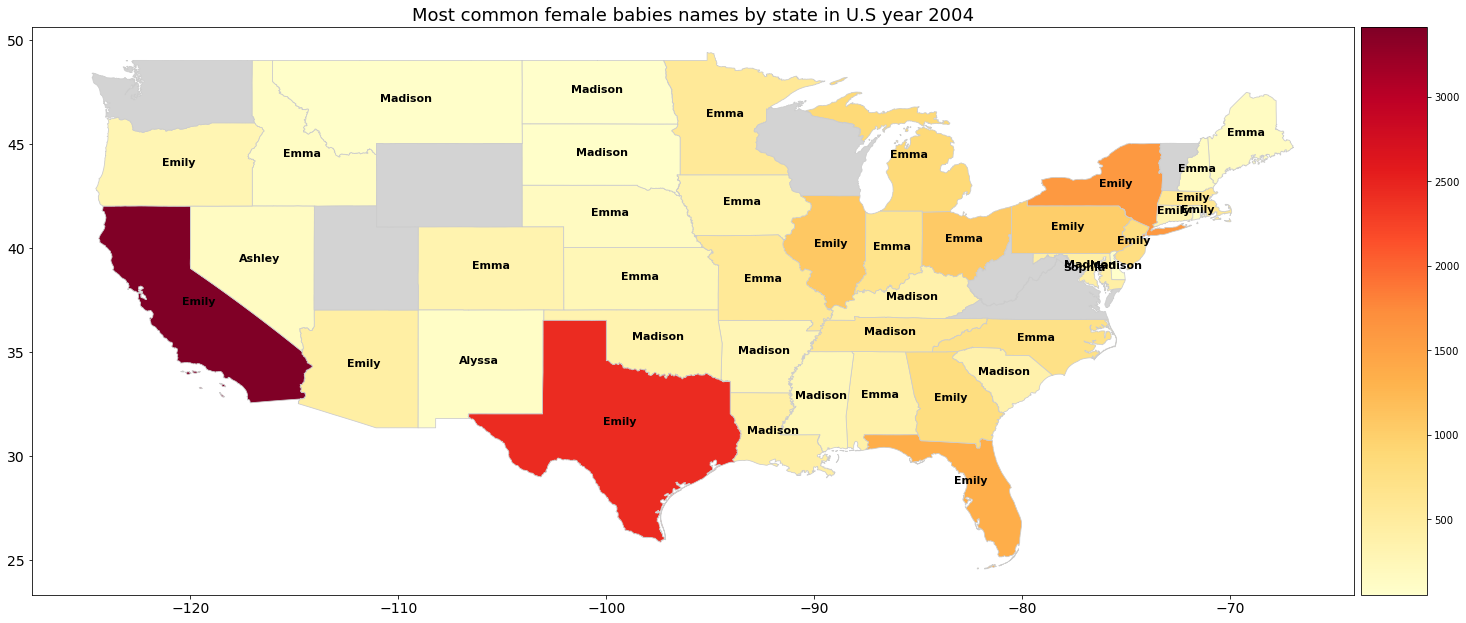

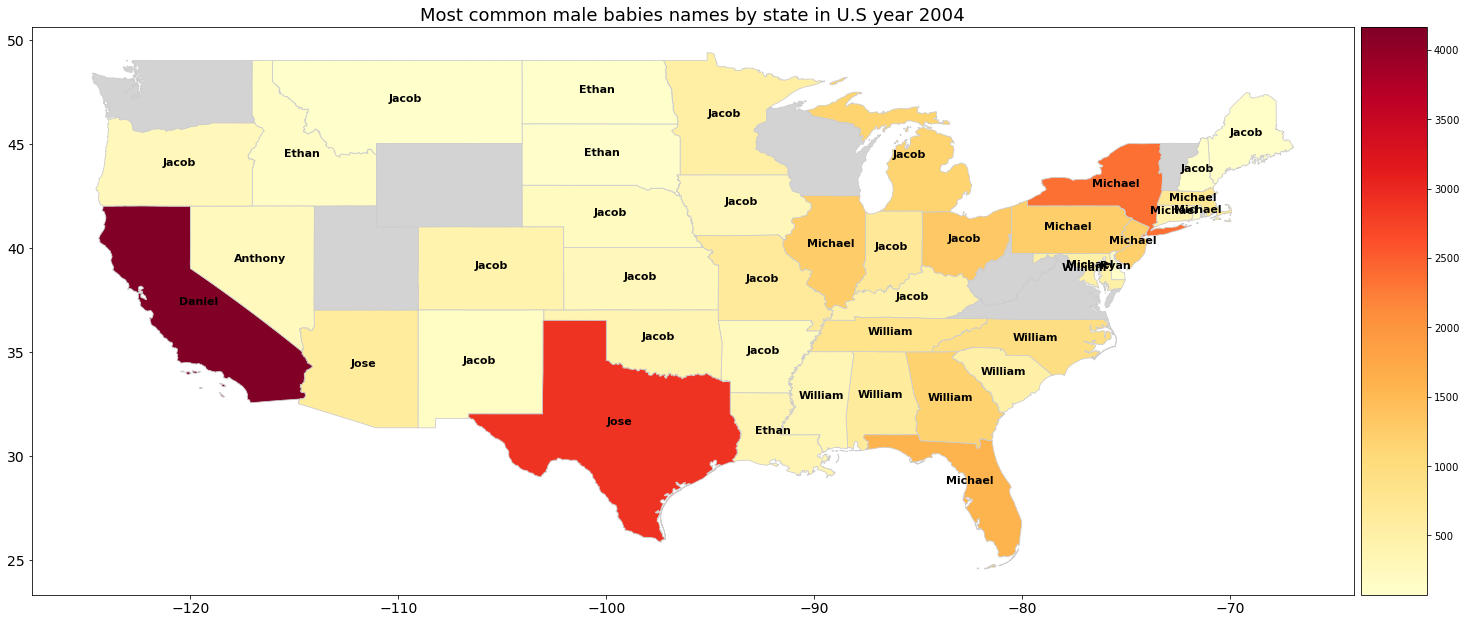

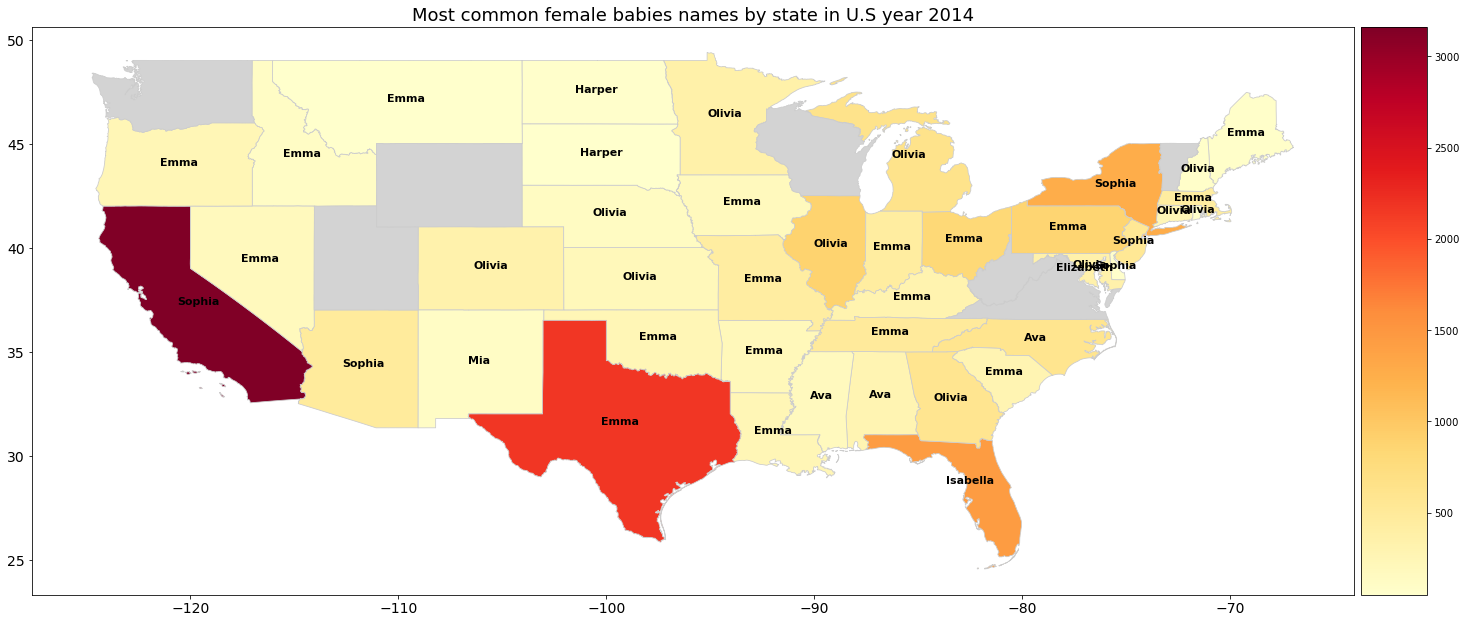

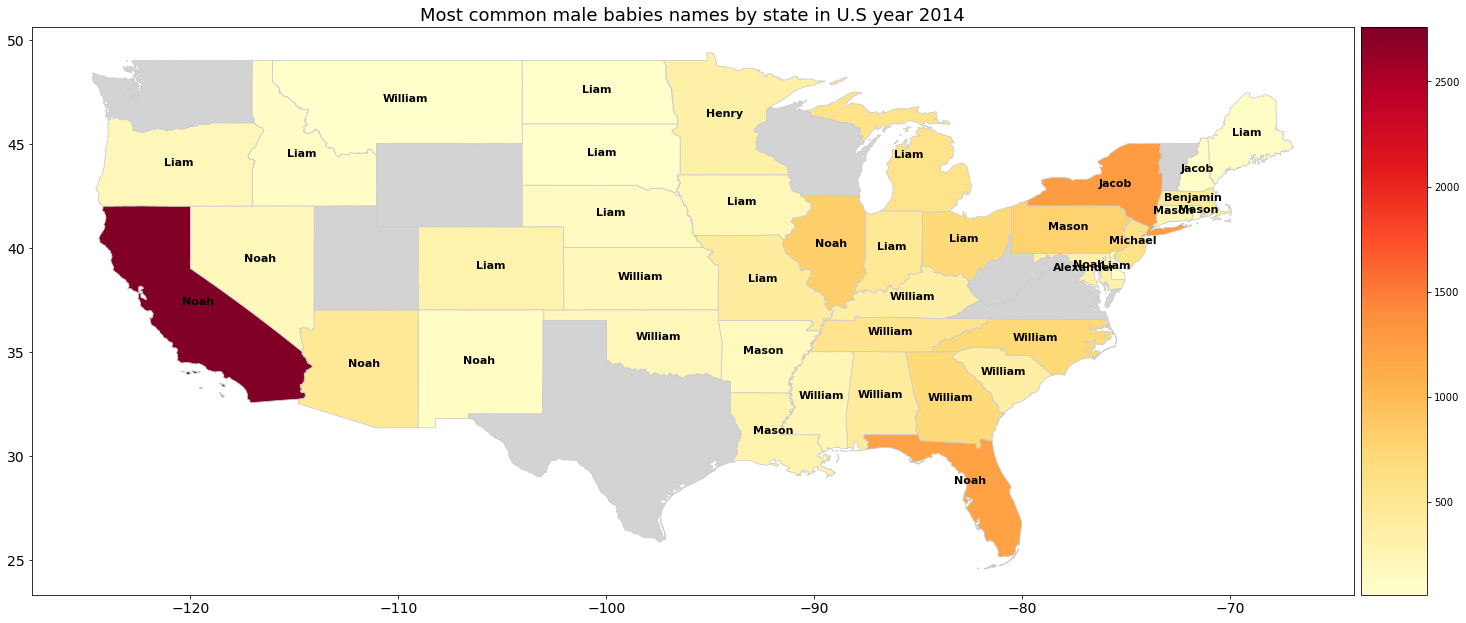

In [10]:
for year in [2004,2014]:
    for gender in ["F","M"]:
        freq_map(merge(continental_usa, results_df, gender=gender, year=year),gender=gender,year=year)

# Gender ratio

Another interesting aspect to study is the gender ratio in between the newborns of the country.

First of all, we need to reset the index of our information dataframe so that we can conveniently groupby.

In [11]:
df.reset_index(inplace=True)

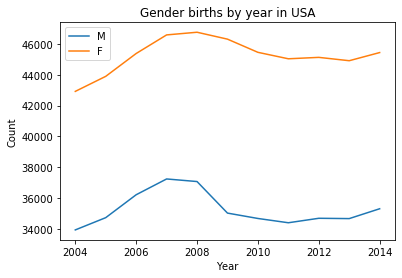

In [12]:
Gender_count = df.groupby(["Year","Gender"]).size()

m_count = [item[1] for item in Gender_count.iteritems() if item[0][1] == "M"]
f_count = [item[1] for item in Gender_count.iteritems() if item[0][1] == "F"]
years = list(df.Year.unique())

plt.plot(years,m_count,label = "M")
plt.plot(years,f_count,label = "F")
plt.legend(loc = "best")
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Gender births by year in USA")
plt.show()